In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.colors import Normalize

# sstの陸面をマスクする関数
def mask(x):
    m = ma.masked_where(x>9999, x)
    z = ma.masked_where(m==0, m)
    #f = ma.filled(z, np.nan) # for masking
    f = ma.filled(z, 0) # for filing with 0
    return f

# (緯度、経度、時間)の三次元情報を => (空間, 時間)の二次元行列に変換する関数
def latlon_to_X(var):
    # 三次元情報それぞれのshapeを取得
    imt, jmt, tmt = var.shape
    # 出力行列Xのshapeを決定
    X = np.zeros((imt*jmt, tmt))
    
    # 行列に変換
    cc = 0 # 行列Xの空間次元のインデックス
    for ii in range(0, imt):
        for jj in range(0, jmt):
            # マスクされている場合は行列に含めない
            if np.isnan(var[ii, jj, 0]) == False:
                X[cc, :] = np.squeeze(var[ii, jj, :])
                cc = cc + 1
    X = np.squeeze(X[0:cc, :]) #squeezeは長さが1の軸が存在する場合に取り除くための保険
    return X

# 二次元行列を三次元に変換する関数
def X_to_latlon(X):
    #　対象とする地域の降水データグリッドサイズが20x20の行列なので、手動でimt,jmtを設定
    imt, jmt = 20, 20
    
    SVDs = np.zeros((imt, jmt))
    
    # 行列を三次元情報に復元
    cc = 0
    for ii in range(0, imt):
        for jj in range(0, jmt):
            SVDs[ii, jj] = X[cc]
            cc += 1
    
    return SVDs

def PQ_to_latlon(P, var):
    # 行列のサイズを得る
    smt, mmt = P.shape
    imt, jmt, kmt = var.shape
    
    # 出力するデータ行列を初期化しておく(この時、最大サイズ(すべて海)を仮定)
    SVDs = np.zeros((imt, jmt, mmt))
    
    # lat-lon行列の作成
    cc = 0 # 何番目のNaNでなはない格子なのかを数えるカウンター
    for ii in range(0, imt):
        for jj in range(0, jmt):
            # マスクされている場合は行列に含めない
            if np.isnan(var[ii, jj, 0]) == False:
                SVDs[ii, jj, :] = P[cc, :]
                cc = cc + 1
            else:
                SVDs[ii, jj, :] = np.nan
    return SVDs

# sstを可視化するための関数
def show_sst(image, img_extent, vmin=-1.5, vmax=1.5):
    projection = ccrs.PlateCarree(central_longitude=180)
    cm = plt.get_cmap('seismic')

    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap=cm,
                     norm=Normalize(vmin=vmin, vmax=vmax))
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='horizontal')
    plt.show()

# prcpを可視化するための関数
def show_prcp(image, vmin=-1.5, vmax=1.5):
    projection =ccrs.PlateCarree(central_longitude=180)
    cm = plt.get_cmap('seismic')
    img_extent = (-90, -70, 5, 25) # location=(N5-25, #90-110)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(image,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     cmap=cm,
                     norm=Normalize(vmin=vmin, vmax=vmax)) # vminとvmaxは結果を見て見やすいように調整
    cbar = fig.colorbar(mat, 
                        extend='both',
                        spacing='proportional',
                        orientation='vertical')
    plt.show()

(42, 165, 24, 72) (42, 165, 20, 20)
(42, 24, 72) (42, 20, 20)


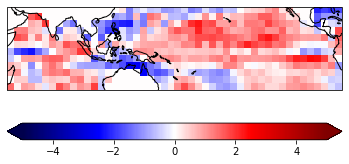

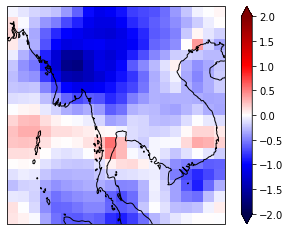

In [23]:
# 訓練/テストデータのディレクトリを参照
traindir = '/docker/mnt/d/research/D2/cnn3'
sst_path = traindir + '/predictors/predictors_coarse_std_Apr_o.npy'
prcp_path = traindir + '/predictant/continuous/pr_1x1_std_MJJASO_thailand.npy'

sst_train = np.squeeze(np.load(sst_path))
prcp_train = np.load(prcp_path)
print(sst_train.shape, prcp_train.shape)

testdir = '/docker/mnt/d/research/D2/cnn3/test'
tors_path = testdir + '/predictors/predictors_coarse_std_Apr_o_1973-2014.npy'
tand_path = testdir + '/continuous/pr_1x1_std_MJJASO_thailand_1973-2014.npy'

sst_test = np.squeeze(np.load(tors_path))
prcp_test = np.load(tand_path)
print(sst_test.shape, prcp_test.shape)

# テストデータセットに含まれるsstとprcpを確認 index=0
model_index = 0
img_extent = (-135, 105, -30, 30)

sst_m0_y1973 = sst_test[model_index, :, :]
sst_masked = mask(sst_m0_y1973)
ocean = sst_masked[6:18, 9:57]
show_sst(ocean, img_extent, vmin=-5, vmax=5)

prcp_m0_y1973 = prcp[model_index, :, :]
show_prcp(prcp_m0_y1973, vmin=-2, vmax=2)

In [30]:
# 今回は42個のモデルモデル番号1850-2014年のデータをもとに特異値行列を計算
train_int = 0 # 用いるモデルの番号始まり
train_fin = 42 # 用いるモデルの番号終わり
training_period = -165 # 用いる年の範囲
mode_index = 0 # 確認したい特異値ベクトルを選択

# sstの行列を作成
umi = sst_train[train_int:train_fin, training_period:, 6:18, 9:57] # 太平洋とインド洋の部分を切り出し
umi = umi.transpose(2,3,0,1) # reshapeするとき用に転置, 時間次元の位置を一番後ろに移動
umi = umi.reshape(12, 48, (train_fin-train_int)*abs(training_period)) # 時間次元 = モデル数*年
umi = mask(umi) # 陸域をマスク
X = latlon_to_X(umi) # SSTの行列を作成

# prcpの行列を作成
ame = prcp_train[train_int:train_fin, training_period:, :, :]# 降水のデータを切り出し
ame = ame.transpose(2,3,0,1) 
ame = ame.reshape(20, 20, (train_fin-train_int)*abs(training_period)) 
Y = latlon_to_X(ame) # PRCPの行列を作成

# 共分散行列を作成
N = X.shape[1] # 時間方向のshape(30年)
C_XY = X@Y.T/N 

# 特異値分解で左右特異行列P, Qを取得
P_train, S, QT_train = np.linalg.svd(C_XY, full_matrices=False)
# 右特異行列を転置
Q_train= QT_train.T

#SSTの左特異ベクトルを描写
sst_SVDs = PQ_to_latlon(P_train, umi)
svd1_sst_map

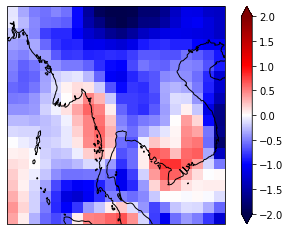

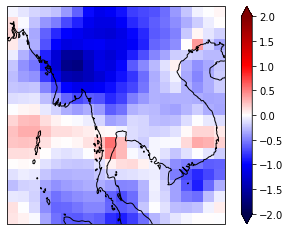

In [35]:
# テスト条件設定
mode_int, mode_fin = 0, 10 # いくつのモードを予測に用いるか(最大400)
test_model_index = 0 # 用いるモデルの番号(year = 1873 + model_index)

# テストデータを整形
umi_test = sst_test[:, 6:18, 9:57] # インド洋と太平洋を切り抜き
umi_test = umi_test.transpose(1,2,0) # 時間次元の位置を一番後ろに移動
umi_test = mask(umi_test) # 陸域をマスク
X_test = latlon_to_X(umi_test) # sstの行列を作成

# 時間展開係数 Aを計算
test_input = X_test[:, test_model_index] # 2014年のsstをインプットとして用意
A_test = P_train.T@test_input # 時間発展係数　=　左特異行列　＊　SST行列
# Aは意味合い的には特異値ベクトルへの射影であり(P_star)に等しい

# PRCP行列を緯度経度座標に復元
grids = 20*20 # 雨データのグリッド数(緯度グリッド20 * 経度グリッド20)
test_output = np.zeros(grids)
# モード毎にprcpを計算して足し合わせる
for i in range(mode_int, mode_fin):
    mode_i = Q_train.T[i]*A_test[i] # PRCPのi番目のモード = 右特異行列 * 時間発展係数B(Bが未知なのでAで代用)
    test_output += mode_i # 各モードを足し合わせる
    
# 可視化
# 特異値解析で得られた降水量分布
prcp_pred = X_to_latlon(test_output)
pred_norm = (prcp_pred-np.mean(prcp_pred))/np.std(prcp_pred)
show_prcp(prcp_pred, vmin=-2, vmax=2)

# 元データから得られた降水量
prcp_label = prcp[test_model_index, :, :]
label_norm = (prcp_label-np.mean(prcp_label))/np.std(prcp_label)
show_prcp(prcp_label, vmin=-2, vmax=2)